In [162]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd
%matplotlib inline

def get_lines_poleval2022(split):
    with open("../data/raw/" + split + "in.tsv", 'r') as f:
        lines = [line for line in f.read().split('\n') if line.strip()]
        lines = [line.split("\t") for line in lines]

        sources = list(zip(*lines))[0]
        texts_ts = list(zip(*lines))[2]

        texts = [re.sub(r':\d+-\d+', '', text) for text in texts_ts] # remove timestamps
        timestamps = [re.findall(r'\d+-\d+', text) for text in texts_ts]


        print(len(texts), "sentences\n", len(set(sources)), "audio files")

    return texts, texts_ts, timestamps


def get_lines_poleval2021(split):
    with open("../data/raw/" + split + "in.tsv", 'r') as f:
        lines = [line for line in f.read().split('\n') if line.strip()]
        lines = [line.split("\t") for line in lines]

        sources = list(zip(*lines))[0]
        texts = list(zip(*lines))[1]

        print(len(texts), "exaples\n", len(set(sources)), "audio files")
    return texts


def get_labels(split, texts, texts_ts=None):
    labels = open("../data/raw/" + split + "expected.tsv", "r").readlines()  
    labels = [label.replace("\n", "") for label in labels]

    if texts_ts is not None:
        for tt, t, l in list(zip(texts_ts, texts, labels))[:2]:
            print(tt, t, l, sep="\n", end="\n\n")
    else:
        for t, l in list(zip(texts, labels))[:2]:
            print(t, l, sep="\n", end="\n\n")

    return labels


def get_no_words(texts):
    # number of words
    lengths = [len(text.split()) for text in texts]
    print("Number of words in examples:")
    print("min: ", min(lengths), "\nmax: ", max(lengths), "\navg: ", sum(lengths) / len(lengths), "\nmedian:", np.median(lengths), "\nall: ", sum(lengths))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.bar(Counter(lengths).keys(), Counter(lengths).values());
    plt.title("Number of words in sentences")
    plt.subplot(1, 2, 2)
    plt.boxplot(lengths);
    plt.show()


def punctuation_stats(labels):  
    labels = [label.replace("...", '…') for label in labels]
    puncts = [re.sub(r'\w|\s', '', label) for label in labels] # exclude letters and spaces
    puncts_number = Counter("".join(puncts)).most_common()
   
    counts = np.zeros((len(puncts_number), len(labels)))
    for i, label in enumerate(labels):
        for j, punct in enumerate(puncts_number):
            counts[j, i] = label.count(punct[0])

    stats = [["", "min", "max", "mean", "std", "total"]] + list(zip([punct[0] for punct in puncts_number], counts.min(axis=1), counts.max(axis=1), counts.mean(axis=1), counts.std(axis=1), list(zip(*puncts_number))[1]))
    print("Stats for punctuation in sentences")
    print(pd.DataFrame(stats))

    unique_puncts = set("".join(puncts))
    unique_puncts = re.escape("".join(unique_puncts))
    unique_puncts = "[" + re.escape("".join(unique_puncts)) + "]" + "{2,}"
    double_punct = re.compile(rf'{unique_puncts}').findall(" ".join(labels))
    print("Double punctuation marks in sentences:")
    pprint(Counter(double_punct).most_common())

    return stats, double_punct

def get_pause_durations(timestamps):
    timestamps = [item for sublist in timestamps for item in sublist]
    durations = []
    beginnings = []
    ends = []
    # word_durations = []

    for timestamp in timestamps:
        numbers = timestamp.split("-")
        beginnings.append(int(numbers[0]))
        ends.append(int(numbers[1]))
        # word_durations.append(int(numbers[1]) - int(numbers[0]))

    for i in range(len(timestamps)-1):
        durations.append(beginnings[i+1] - ends[i])
        if durations[i] < 0: # it means the new recording started
            durations[i] = np.nan        
    durations.append(np.nan) # for the last sign
    return durations


def get_punctuation_for_pause_from_dataset(durations, texts, path="../data/pl/train_2022_allpunct"):
    words_old = []
    for text in texts:
        words_old.extend(text.split())

    with open(path, "r") as f:
        lines = f.read().splitlines()

    lines = [line.split("\t") for line in lines]
    words, interpunction = list(zip(*lines))

    list(zip(words, words_old, interpunction, durations))[4636:4637]

    excluded_signs = '\%\+\"\*\/\\=$€\(\)\[\]\@·;'
    word_signs = f"[\w{excluded_signs}]+"
    punctuation_signs = f"(?![\s{excluded_signs}])\W|…"

    # Words from "in" dataset sometimes have punctuation inside (e.g. "…", "à", "Dobraю", "-" inside words).
    # They get split in the "allpunct" dataset. We have split the words in the "in" dataset as well,
    # to match the lengths of the durations and words lists.
    
    # remove punctuation signs from words
    i=0
    while i!=len(words):
        if words[i] != words_old[i].lower():
            if words_old[i] == "…":
                words_old.pop(i)
                durations.pop(i)
                i-=1
                # print("found …")

            elif words_old[i] == "à" or words_old[i] == "Dobraю":
                pass

            else:
                elements = re.compile(rf"{punctuation_signs}|{word_signs}|\n").findall(words_old[i]) # alfanumeric or non-alphanumeric characters (punctuation)
                # print(i, words[i], words_old[i], elements)
                words_old.insert(i, elements[2])
                words_old.insert(i, elements[0])
                words_old.pop(i+2)
                durations.insert(i, durations[i])
                durations.insert(i, None)
                durations.pop(i+2)
        i+=1

    return interpunction, durations


def plot_pause_durations(interpunction, durations):
    
    lengths = pd.DataFrame(list(zip(interpunction, durations)), columns=["interpunction", "duration"])
    groups = lengths.groupby('interpunction')

    # Plotting histograms for each group at one figure
    for interp, group_df in groups:
        plt.hist(group_df['duration'], alpha=0.7, label=interp, log=True, bins=100)
    plt.title("Pause durations for punctuation marks (log scale)")
    plt.legend()
    plt.show()

    for interp, group_df in lengths[lengths["duration"] < 2000].groupby('interpunction'):
        plt.hist(group_df['duration'], alpha=0.7, label=interp, log=True, bins=100)
    plt.title("Pause durations for punctuation marks (log scale, limited to < 2000 ms)")
    plt.legend()
    plt.show()


    # Plotting histograms for each group
    plt.subplots(4,2, figsize = (15, 10))

    for i, (legend, group_df) in enumerate(groups):
        plt.subplot(4,2, i+1)
        plt.hist(group_df['duration'], bins=100, log=True)
        mean = groups["duration"].mean()[legend]
        std = groups["duration"].std()[legend]
        median = groups["duration"].median()[legend]
        plt.axvline(x = mean, label = 'mean', color='green')
        plt.axvline(x = mean-std, label = 'std', linestyle='--', color='green')
        plt.axvline(x = mean+std, linestyle='--', color='green')
        plt.axvline(x = median, label = 'median', color='red')
        plt.xlabel("Duration [ms]")
        plt.ylabel("Counts")
        plt.title(legend)

    plt.tight_layout()
    plt.suptitle("Pause durations for punctuation marks (log scale)")
    # plt.subplot(4,2, 8)
    plt.legend()
    plt.show()

    lengths["missing"] = lengths["duration"].isna()
    desc = groups.describe()

    desc["counts with nan"] = groups["missing"].count()
    desc["no missing"] = groups["missing"].sum()
    desc["missing %"] = (desc["no missing"] / desc["counts with nan"]) * 100
    desc["IQR"] = desc["duration"]["75%"] - desc["duration"]["25%"]
                     
    display(desc)


<>:123: SyntaxWarning: invalid escape sequence '\%'
<>:124: SyntaxWarning: invalid escape sequence '\w'
<>:125: SyntaxWarning: invalid escape sequence '\s'
<>:125: SyntaxWarning: invalid escape sequence '\W'
<>:123: SyntaxWarning: invalid escape sequence '\%'
<>:124: SyntaxWarning: invalid escape sequence '\w'
<>:125: SyntaxWarning: invalid escape sequence '\s'
<>:125: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_5846/2765169880.py:123: SyntaxWarning: invalid escape sequence '\%'
  excluded_signs = '\%\+\"\*\/\\=$€\(\)\[\]\@·;'
/tmp/ipykernel_5846/2765169880.py:124: SyntaxWarning: invalid escape sequence '\w'
  word_signs = f"[\w{excluded_signs}]+"
/tmp/ipykernel_5846/2765169880.py:125: SyntaxWarning: invalid escape sequence '\s'
  punctuation_signs = f"(?![\s{excluded_signs}])\W|…"
/tmp/ipykernel_5846/2765169880.py:125: SyntaxWarning: invalid escape sequence '\W'
  punctuation_signs = f"(?![\s{excluded_signs}])\W|…"


## Poleval 2022

------------------ poleval2022/train/ -----------------
10601 sentences
 62 audio files
I:5880-5880 teraz:5940-6180 mamy:6330-6450 drugi:6480-6900 dzień:6960-7080 takiej:7170-7410 ładnej:7440-7650 pogody:7830-8400 Ała:8430-8430 Nie:8760-8820 bij:8850-8970 mnie:9120-9330 kijem:9450-9870 To:10020-10080 boli:10170-10260
I teraz mamy drugi dzień takiej ładnej pogody Ała Nie bij mnie kijem To boli
I teraz mamy drugi dzień takiej ładnej pogody... Ała! Nie bij mnie kijem! To boli!

Stasio:11895-12285 Bo:13485-13545 nie:13605-13665 dostaniesz:13725-14175 jogurciku:14505-14655
Stasio Bo nie dostaniesz jogurciku
Stasio! Bo nie dostaniesz jogurciku!

Number of words in examples:
min:  1 
max:  92 
avg:  8.868408640694273 
median: 6.0 
all:  94014


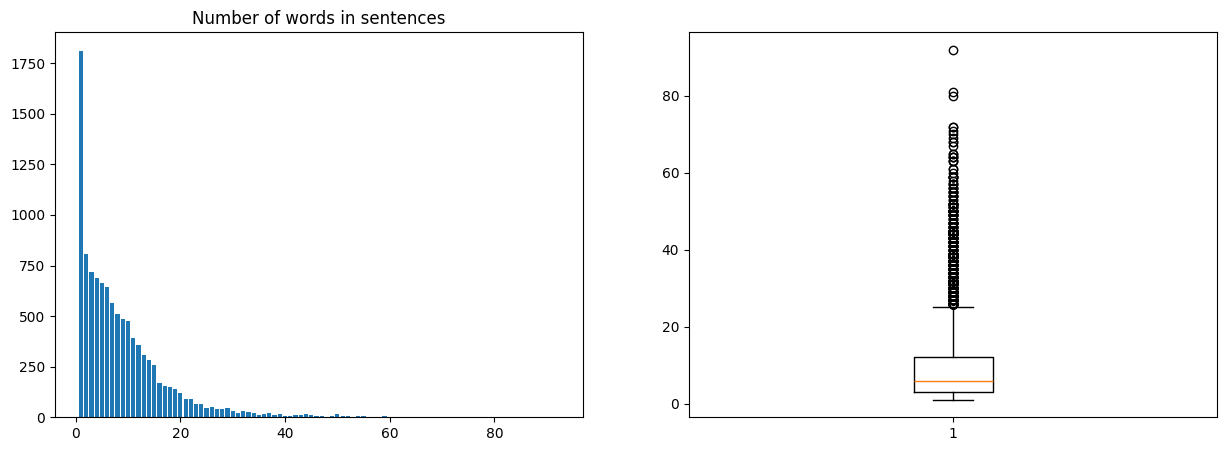

Stats for punctuation in sentences
   0    1     2         3         4      5
0     min   max      mean       std  total
1  ,  0.0  19.0  1.001604  1.607893  10618
2  .  0.0   8.0   0.69484  0.769539   7366
3  …  0.0  11.0  0.417225  0.965962   4423
4  ?  0.0   4.0  0.148288   0.40524   1572
5  !  0.0   3.0  0.022828  0.182344    242
6  -  0.0   3.0   0.01481   0.13127    157
Double punctuation marks in sentences:
[]

Punctuation in raw texts
Stats for punctuation in sentences
   0    1    2         3         4      5
0     min  max      mean       std  total
1  -  0.0  3.0  0.009999   0.10681    106
2  …  0.0  2.0  0.004622  0.071881     49
3  '  0.0  1.0  0.001415  0.037589     15
Double punctuation marks in sentences:
[]



------------------ poleval2022/dev-0/ -----------------
409 sentences
 7 audio files
Kłaniam:10320-10560 się:10680-10710 Dzień:10770-10860 dobry:10920-11100 Rafał:11250-11490 Nowak:11580-11880 Proszę:12000-12330 pana:12420-12630 na:13020-13050 szczepienie:13200-1

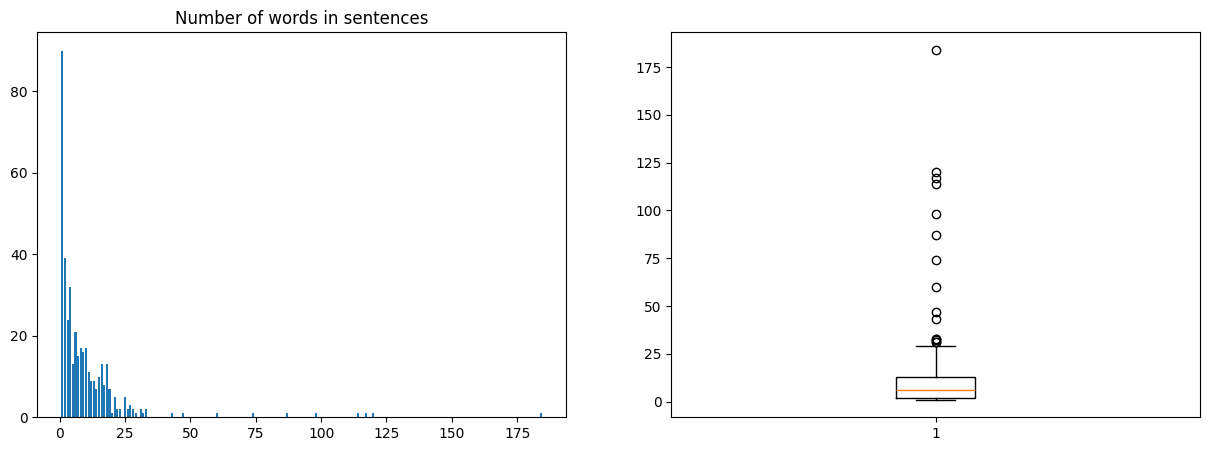

Stats for punctuation in sentences
   0    1     2         3         4      5
0     min   max      mean       std  total
1  ,  0.0  18.0  1.278729  2.180277    523
2  .  0.0  10.0   1.02445  1.133784    419
3  …  0.0   3.0  0.234719  0.488166     96
4  ?  0.0   2.0  0.212714  0.449106     87
5  -  0.0   2.0  0.022005  0.162514      9
6  !  0.0   1.0  0.012225  0.109889      5
7  @  0.0   1.0  0.002445  0.049386      1
Double punctuation marks in sentences:
[]

Punctuation in raw texts
Stats for punctuation in sentences
   0    1    2         3         4      5
0     min  max      mean       std  total
1  -  0.0  2.0  0.022005  0.162514      9
2  @  0.0  1.0  0.002445  0.049386      1
3  .  0.0  1.0  0.002445  0.049386      1
Double punctuation marks in sentences:
[]





In [2]:
for split in ["poleval2022/train/", "poleval2022/dev-0/"]:
    print("------------------", split, "-----------------")
    texts, texts_ts, timestamps = get_lines_poleval2022(split)
    labels = get_labels(split, texts, texts_ts)
    get_no_words(texts)
    punctuation_stats(labels)
    print("\nPunctuation in raw texts")
    punctuation_stats(texts)
    print("\n\n")

W poleval2022 jest niekonsekwencja w traktowaniu znaków. Niektóre znaki - …  i jedna kropka zostały zostawione w danych wejściowych, ' zostały usunięte w etykietach. @ nie jest traktowna jako znak interpunkcyjny.

### Długość pauz

10601 sentences
 62 audio files


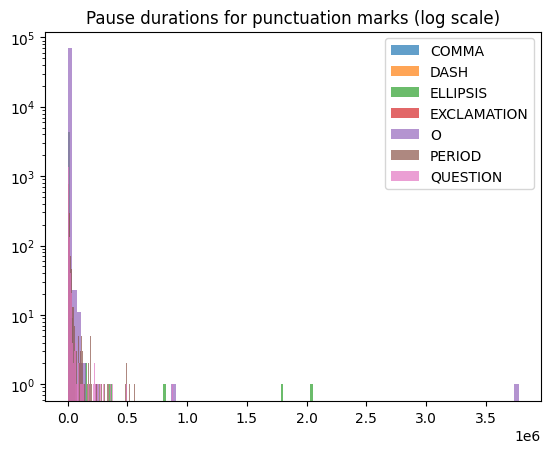

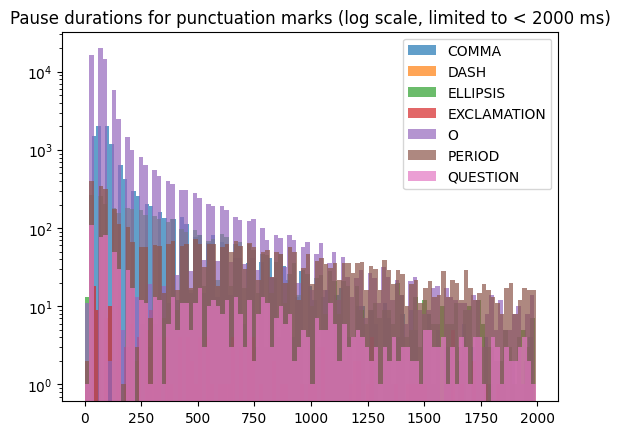

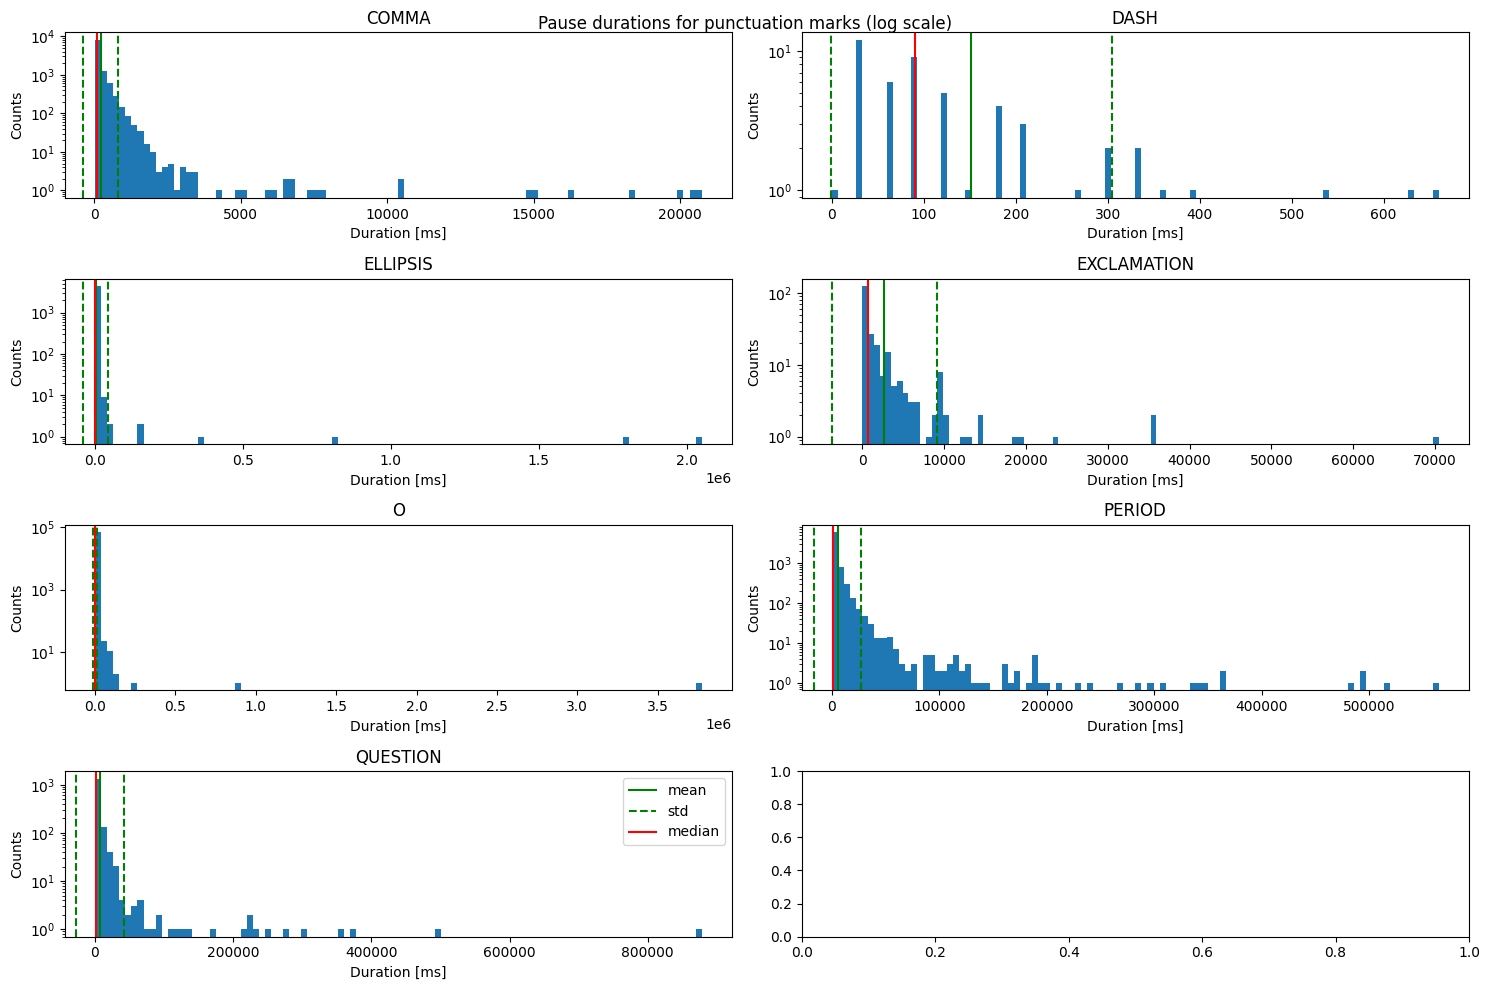

duration                                                  \
                 count         mean           std   min    25%     50%   
interpunction                                                            
COMMA          10618.0   221.217649    592.924909  30.0   60.0    90.0   
DASH              51.0   151.764706    152.547775   0.0   45.0    90.0   
ELLIPSIS        4388.0  2051.206928  43468.768755   0.0  180.0   390.0   
EXCLAMATION      237.0  2726.240506   6416.351241  30.0  210.0   690.0   
O              69712.0   317.696552  14838.336433   0.0   60.0    60.0   
PERIOD          7257.0  5442.691884  21891.839815   0.0  360.0  1204.0   
QUESTION        1569.0  7159.297642  34509.711812   0.0  210.0  1444.0   

                                 counts with nan no missing  missing %     IQR  
                  75%        max                                                
interpunction                                                                   
COMMA           210.0    20730.0           10618          0   0.000000   150.0  
DASH            195.0      660.0             157        106  67.515924   150.0  
ELLIPSIS        750.0  2051342.0            4392          4   0.091075   570.0  
EXCLAMATION    2710.0    70421.0             242          5   2.066116  2500.0  
O               120.0  3773871.0           69739         27   0.038716    60.0  
PERIOD         4350.0   564776.0            7366        109   1.479772  3990.0  
QUESTION       4840.0   878157.0            1572          3   0.190840  4630.0

In [175]:
texts, texts_ts, timestamps = get_lines_poleval2022("poleval2022/train/")
durations = get_pause_durations(timestamps)
interpunction, durations = get_punctuation_for_pause_from_dataset(durations, texts, "../data/pl/train_2022_allpunct")
desc = plot_pause_durations(interpunction, durations)


In [174]:
interpunction = np.array(interpunction)
(interpunction != "O").sum(), (interpunction == "O").sum()

(24347, 69739)

Duża liczba nan w dash wynika z tego, że są one łącznikami wyrazów. Kropki i wykrzykniki występują na końcu zdania, więc często kończą dokument i nic po nich nie ma.

Odchylenia std są gigantyczne, bo są liczne wartości odstające. Ale meiany nie wyglądają źle. może wykrzykniki mają duży IQR, ale to dlatego, że jest ich mało. Kropki i znaki zapytania mają długie odstępy. Może się nauczy odróżniać O od znaku interpunkcyjnego, co by miało już jakiś sens, bo "O" jest klasą dominującą.

## Poleval 2021

------------------ poleval2021/train/ -----------------
800 exaples
 800 audio files
w wywiadzie dla " polski " jarosław kaczyński podkreślił że informacje dotyczące radosława sikorskiego zagrażają interesowi państwa " to naprawdę wszystko co mogę na ten temat powiedzieć " odpowiedział gdy dziennikarz pytał o bardziej szczegółowe informacje premier kaczyński sugeruje że dobry kandydat po na szefa dyplomacji to np jacek saryusz wolski wymieniony polityk zyskał uznanie braci kaczyńskich za dotychczasową działalność w charakterze dyplomaty i dużą wiedzę premier krytycznie ocenia również dotychczasowe poczynania po " gabinet cieni i inne podobne pomysły okazały się fikcją świadczą o tym kłopoty ze znajdywaniem kolejnych ministerstw cały czas nie wiadomo kto obsadzi które ministerstwo a tam gdzie już wiadomo to nie ma się z czego cieszyć " mówił kaczyński stwierdził także że " uważny obserwator życia publicznego musi dostrzegać też rolę w tym wszystkim jana krzysztofa bieleckiego będzie oso

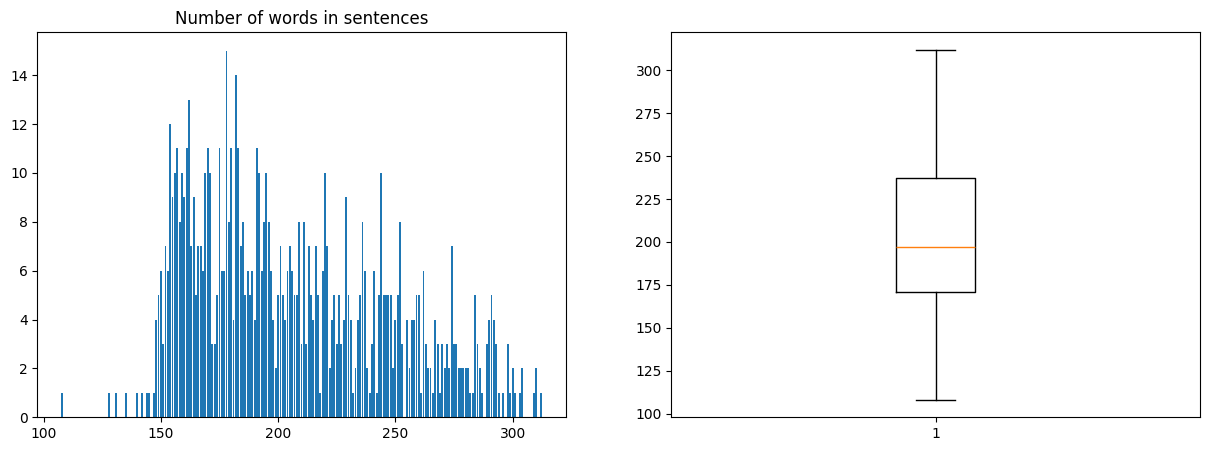

Stats for punctuation in sentences
    0    1     2         3         4      5
0      min   max      mean       std  total
1   .  2.0  36.0  13.08625  4.537214  10469
2   ,  0.0  39.0    12.665  5.717322  10132
3   "  0.0  74.0   4.23125  6.155508   3385
4   -  0.0  17.0      3.06  2.648849   2448
5   :  0.0  12.0   1.14125  1.696702    913
6   ?  0.0  12.0   0.99625  1.985255    797
7   %  0.0  22.0   0.22125   1.36191    177
8   '  0.0   6.0    0.1975  0.702491    158
9   !  0.0   7.0    0.1475  0.550676    118
10  ;  0.0  17.0    0.1125  0.793627     90
11  +  0.0   5.0   0.04375  0.334419     35
12  )  0.0   4.0    0.0275    0.2434     22
13  (  0.0   1.0   0.01125  0.105468      9
14  …  0.0   1.0   0.00375  0.061122      3
15  ]  0.0   2.0   0.00375  0.078968      3
16  /  0.0   2.0    0.0025  0.070666      2
17  [  0.0   1.0   0.00125  0.035333      1
18  €  0.0   1.0   0.00125  0.035333      1
19  ·  0.0   1.0   0.00125  0.035333      1
Double punctuation marks in sentences:
[(

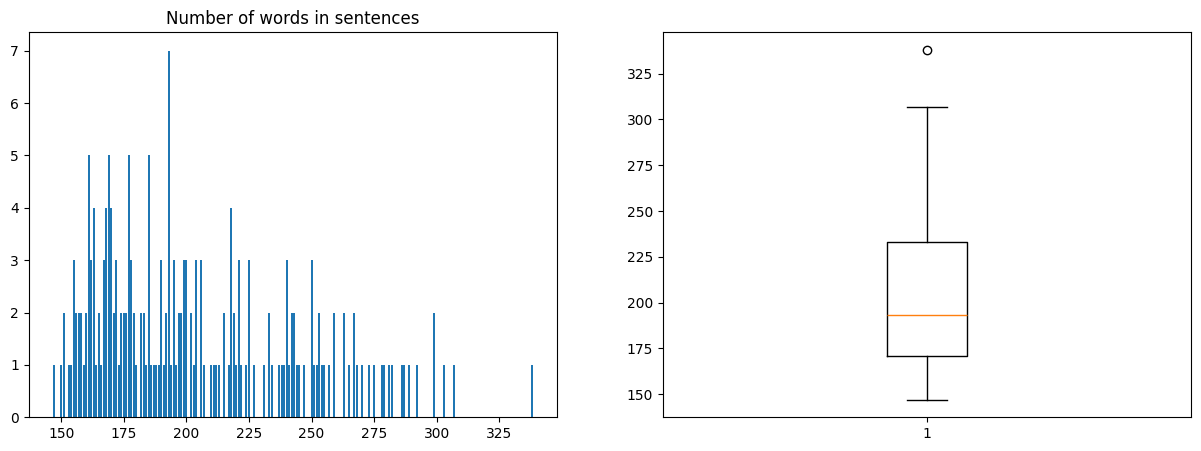

Stats for punctuation in sentences
    0    1     2       3         4      5
0      min   max    mean       std  total
1   .  2.0  25.0  12.865  4.039403   2573
2   ,  1.0  71.0   12.49   6.56429   2498
3   "  0.0  30.0     3.6  4.417013    720
4   -  0.0  26.0   3.105  3.137511    621
5   :  0.0  92.0   1.615  6.710199    323
6   ?  0.0   8.0   0.745  1.757832    149
7   %  0.0  16.0   0.325  1.723187     65
8   '  0.0   6.0   0.155  0.648826     31
9   !  0.0   4.0   0.115  0.501772     23
10  ;  0.0   2.0   0.055  0.248948     11
11  ]  0.0   2.0    0.01  0.141067      2
12  )  0.0   1.0    0.01  0.099499      2
13  $  0.0   1.0   0.005  0.070534      1
14  +  0.0   1.0   0.005  0.070534      1
Double punctuation marks in sentences:
[('"-', 103),
 ('".', 75),
 ('",', 48),
 ('"?', 14),
 ('%-', 14),
 ('%.', 9),
 ('%,', 9),
 ('":', 2),
 ("'.", 2),
 ('$.', 1),
 (']],', 1),
 (').', 1),
 ("'?", 1),
 ("';", 1)]

Punctuation in raw texts
Stats for punctuation in sentences
   0    1     2   

In [5]:
for split in ["poleval2021/train/", "poleval2021/test-A/"]:
    print("------------------", split, "-----------------")
    texts = get_lines_poleval2021(split)
    labels = get_labels(split, texts)
    get_no_words(texts)
    punctuation_stats(labels)
    print("\nPunctuation in raw texts")
    punctuation_stats(texts)
    print("\n\n")    

W poleval 2021 niektóre znaki nie są traktowane jako interpunkcja i nie są usuwane z przykładów wejściowych.

In [6]:
# Add duration for each word

import re
times = []
matches = re.findall(r':\d+-\d+', texts_ts[0])
for match in matches:
    match = match[1:].split("-")
    times.append(int(match[1]) - int(match[0]))

text_dur = list(zip(texts[0].split(" "), times))
text_dur = [str(x) for t in text_dur for x in t]
" ".join(text_dur)

'co 0 znaczy 240 że 120 beginki 420 " 120 padły 240 ofiarą 210 reformacji 570 " 0 grzesie2k 60 wpis 120 na 210 słabym 420 poziomie 60 bzdurna 90'

# herbert

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained("allegro/herbert-klej-cased-v1")
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1")

encoded_input = tokenizer.encode("Kubuś nie zjadł jogurciku, bo bił mamę kijem", return_tensors="pt")
outputs = model(encoded_input)

/mnt/dane/.conda/envs/mgr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [9]:
TOKEN_IDX = {
    'bert': {
        'START_SEQ': 101,
        'PAD': 0,
        'END_SEQ': 102,
        'UNK': 100
    },
    'xlm': {
        'START_SEQ': 0,
        'PAD': 2,
        'END_SEQ': 1,
        'UNK': 3
    },
    'roberta': {
        'START_SEQ': 0,
        'PAD': 1,
        'END_SEQ': 2,
        'UNK': 3
    },
    'albert': {
        'START_SEQ': 2,
        'PAD': 0,
        'END_SEQ': 3,
        'UNK': 1
    },
}


TOKEN_STYLE = 'xlm'

en_file_path = "punctuation-restoration-master/data/en/dev2012"
pl_file_path = "data/train/expected_prepared.tsv"

sequence_len = 25
token_style = 'xlm'
# 'O' -> No punctuation
punctuation_dict = {'O': 0, 'COMMA': 1, 'PERIOD': 2, 'QUESTION': 3}

In [10]:
def parse_data(file_path, tokenizer, sequence_len, token_style):
    """

    :param file_path: text file path that contains tokens and punctuations separated by tab in lines
    :param tokenizer: tokenizer that will be used to further tokenize word for BERT like models
    :param sequence_len: maximum length of each sequence
    :param token_style: For getting index of special tokens in config.TOKEN_IDX
    :return: list of [tokens_index, punctuation_index, attention_masks, punctuation_mask], each having sequence_len
    punctuation_mask is used to ignore special indices like padding and intermediate sub-word token during evaluation
    """
    data_items = []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line for line in f.read().split('\n') if line.strip()] # one line is one word and its punctuation
        idx = 0
        # loop until end of the entire text
        while idx < len(lines):
            # beginning of a new sequence
            x = [TOKEN_IDX[token_style]['START_SEQ']]
            y = [0]
            y_mask = [1]  # which positions we need to consider while evaluating i.e., ignore pad or sub tokens

            # loop until we have required sequence length
            # -1 because we will have a special end of sequence token at the end
            while len(x) < sequence_len - 1 and idx < len(lines):
                word, punc = lines[idx].split('\t')
                # print(word, punc)
                tokens = tokenizer.tokenize(word)
                # if taking these tokens exceeds sequence length we finish current sequence with padding
                # then start next sequence from this token
                if len(tokens) + len(x) >= sequence_len:
                    break
                else:
                    for i in range(len(tokens) - 1):
                        x.append(tokenizer.convert_tokens_to_ids(tokens[i]))
                        y.append(0)
                        y_mask.append(0)
                    if len(tokens) > 0:
                        x.append(tokenizer.convert_tokens_to_ids(tokens[-1]))
                    else:
                        x.append(TOKEN_IDX[token_style]['UNK'])
                    y.append(punctuation_dict[punc])
                    y_mask.append(1)
                    idx += 1
            x.append(TOKEN_IDX[token_style]['END_SEQ'])
            y.append(0)
            y_mask.append(1)
            if len(x) < sequence_len:
                x = x + [TOKEN_IDX[token_style]['PAD'] for _ in range(sequence_len - len(x))]
                y = y + [0 for _ in range(sequence_len - len(y))]
                y_mask = y_mask + [0 for _ in range(sequence_len - len(y_mask))]
            attn_mask = [1 if token != TOKEN_IDX[token_style]['PAD'] else 0 for token in x]
            
            # x – all tokens for the word, no punctuation, special tokens in the beginning and end (e.g. ["<\s>", "ad", "#am"])
            # y – 0 for all tokens for the word, then punctuation (e.g. [0, 0, 0])
            # attn_mask – mask for the padding tokens (1 if not padding, 0 otherwise) (e.g. [1, 1, 1])
            # y_mask – mask for the punctuation tokens (1 if for token ending a word, 0 otherwise) (e.g. [0, 0, 1])
            data_items.append([x, y, attn_mask, y_mask])
            break
    return data_items

In [11]:
data_items = parse_data(pl_file_path, tokenizer, sequence_len, token_style)

for token, punct in zip(tokenizer.convert_ids_to_tokens(data_items[0][0]), data_items[0][3]):
    print(token, punct)

print(data_items[0][0][1])

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/expected_prepared.tsv'

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, files, tokenizer, sequence_len, token_style, is_train=False, augment_rate=0.1,
                 augment_type='substitute'):
        """

        :param files: single file or list of text files containing tokens and punctuations separated by tab in lines
        :param tokenizer: tokenizer that will be used to further tokenize word for BERT like models
        :param sequence_len: length of each sequence
        :param token_style: For getting index of special tokens in config.TOKEN_IDX
        :param augment_rate: token augmentation rate when preparing data
        :param is_train: if false do not apply augmentation
        """
        if isinstance(files, list):
            self.data = []
            for file in files:
                self.data += parse_data(file, tokenizer, sequence_len, token_style)
        else:
            self.data = parse_data(files, tokenizer, sequence_len, token_style)
        self.sequence_len = sequence_len
        self.augment_rate = augment_rate
        self.token_style = token_style
        self.is_train = is_train
        self.augment_type = augment_type

    def __len__(self):
        return len(self.data)

    def _augment(self, x, y, y_mask):
      pass # not important for us now

    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.data[index][1]
        attn_mask = self.data[index][2]
        y_mask = self.data[index][3]

        if self.is_train and self.augment_rate > 0:
            x, y, attn_mask, y_mask = self._augment(x, y, y_mask)

        x = torch.tensor(x)
        y = torch.tensor(y)
        attn_mask = torch.tensor(attn_mask)
        y_mask = torch.tensor(y_mask)

        return x, y, attn_mask, y_mask


In [ ]:
en_dataset = Dataset(pl_file_path, tokenizer, sequence_len, token_style)

en_dataset[0]

(tensor([    0,    17,   491,   493,  1327,   756,   801,  2828,   236, 15776,
           324,    22,   387,   592,   161,   955,  2695,    25, 17472,   863,
         22867,    94,    22, 46112,     1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
         0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
         1]))

In [ ]:
import re
# test data
with open("data_raw/test-A/in.tsv", 'r') as f:
    lines = [line for line in f.read().split('\n') if line.strip()]

lines = [line.split("\t") for line in lines]

texts_ts = list(zip(*lines))[2]
texts = [re.sub(r':\d+-\d+', '', text) for text in texts_ts] # remove timestamps


texts[:50]

['No dzień dobry pani',
 'To może na początek takie pytanie czy państwo pobieracie opłaty za karty które których się nie ma',
 'Normalna praktyka banku jest',
 'Ale nie wiem czy ona jest zastrzeżona ale na pewno nie jestem w jej posiadaniu bo do mnie nie dotarła żadna karta a tu widać nalicza się opłata za kar',
 'No dobrze',
 'No dobrze Ja się nazywam Tomasz Adamczyk',
 'To będzie tak',
 'osiemdziesiąt siedem',
 'zero sześć dziewiętnaście zero pięćdziesiąt dwa trzydzieści trzy',
 'Tak posiadam Nawet kilka',
 'A ja nie wiem gdzie państwo ją wysłali To nie ja ją wysyłąłem To państwo powinni wiedzieć gdzie wysyłali kartę',
 'Dobrze',
 'Aktualny czy czy zameldowania czy czy ten do korespondencji bo są dwa różne',
 'Dobrze to jest Limanowskiego sto dwadzieścia sześć a w Łodzi',
 'Ja już państwu ja podawałwm podawałem ten adres wcześniej co on się jakoś nie wiem nie zaktualizował',
 'To stary adres jest',
 'Nie Nie nie',
 'Limanowskiego 124 a',
 'Nie nie To jest dom',
 'Tak tak W Łodzi oczy

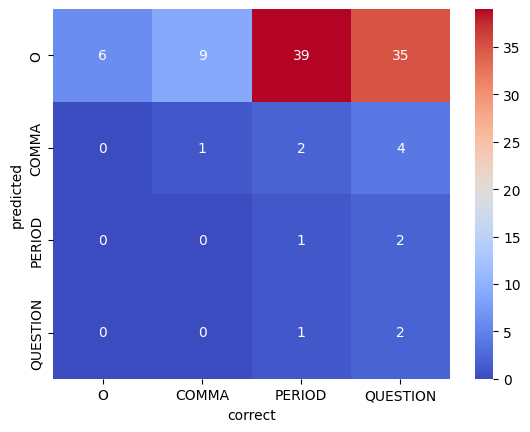

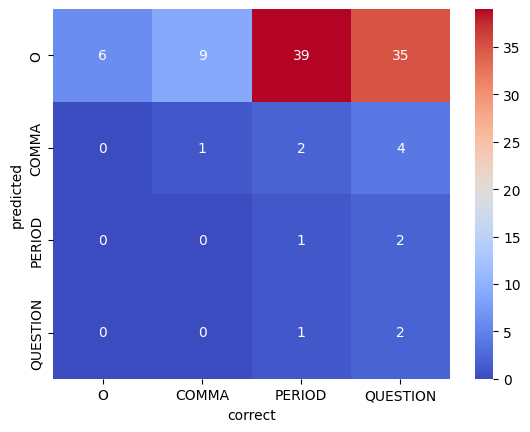

In [ ]:
import numpy as np
import seaborn as sns

punctuation_dict = {'O': 0, 'COMMA': 1, 'PERIOD': 2, 'QUESTION': 3}
cm = np.array(
[[ 6,  9, 39, 35],
[ 0 , 1 , 2 , 4],
[ 0 , 0 , 1 , 2],
[ 0 , 0 , 1 , 2]])

# plot 
cm_img = sns.heatmap(cm, annot=True, cmap="coolwarm", xticklabels=punctuation_dict.keys(), yticklabels=punctuation_dict.keys())
cm_img.set_xlabel("correct")
cm_img.set_ylabel("predicted")
cm_img.get_figure()
# mlflow.log_figure(cm_img.get_figure(), "confusion_matrix.png")


In [ ]:
import re 
text = "Ala ma kota?\nTak, ma.\nA kot ma Alę."

excluded_signs = '\%\+\"\*\/\\=$€\(\)\[\]\'@·;'
word_signs = f"[\w{excluded_signs}]+"
punctuation_signs = f"(?![\s{excluded_signs}])\W|…|"
elements = re.compile(rf"{punctuation_signs}|{word_signs}|\n").findall(text) # alfanumeric or non-alphanumeric characters (punctuation)
elements = [element for element in elements if element.strip(' ')] # discard empty strings

punctuation_mask = []
for i, element in enumerate(elements):
    if re.match(rf"{word_signs}", element):
        punctuation_mask.append(0)
    else:
        elements[i] = elements[i].replace(" ", "")
        punctuation_mask.append(1)

list(zip(elements, punctuation_mask))

['', 'Ala', '', '', 'ma', '', '', 'kota', '?', '', '\n', '', 'Tak', ',', '', '', 'ma', '.', '', '\n', '', 'A', '', '', 'kot', '', '', 'ma', '', '', 'Alę', '.', '']


[('Ala', 0),
 ('ma', 0),
 ('kota', 0),
 ('?', 1),
 ('\n', 1),
 ('Tak', 0),
 (',', 1),
 ('ma', 0),
 ('.', 1),
 ('\n', 1),
 ('A', 0),
 ('kot', 0),
 ('ma', 0),
 ('Alę', 0),
 ('.', 1)]

In [ ]:
from dataset import *
from transformers import AutoTokenizer

token_style = 'bert'
sequence_len = 256
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1")
data_items = parse_data("../data/pl/test_pl", tokenizer, sequence_len, token_style)
data_items


loading configuration file config.json from cache at /home/anna/.cache/huggingface/hub/models--allegro--herbert-klej-cased-tokenizer-v1/snapshots/22f03e76fc129ea8f15a92e7213d5beeba83f4c8/config.json
Model config XLMConfig {
  "_name_or_path": "allegro/herbert-klej-cased-tokenizer-v1",
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": 0,
  "causal": false,
  "dropout": 0.1,
  "emb_dim": 2048,
  "embed_init_std": 0.02209708691207961,
  "end_n_top": 5,
  "eos_index": 1,
  "gelu_activation": true,
  "init_std": 0.02,
  "is_encoder": true,
  "lang_id": 0,
  "layer_norm_eps": 1e-12,
  "mask_index": 5,
  "mask_token_id": 0,
  "max_position_embeddings": 512,
  "model_type": "xlm",
  "n_heads": 16,
  "n_langs": 1,
  "n_layers": 12,
  "pad_index": 2,
  "pad_token_id": 2,
  "sinusoidal_embeddings": false,
  "start_n_top": 5,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "first",
  "summary_use_proj":

[[[101,
   55,
   5970,
   65,
   70,
   28425,
   55,
   172,
   8464,
   30760,
   976,
   94,
   94,
   14558,
   6579,
   25,
   25,
   658,
   297,
   25,
   65,
   226,
   3968,
   44189,
   30,
   55,
   30760,
   976,
   25,
   1561,
   18,
   1207,
   25,
   180,
   15241,
   22,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
